In [ ]:
%cd drive/My\ Drive/Indenpedent\ Study

/content/drive/My Drive/Indenpedent Study


In [ ]:
!ls

data	transformers	 wikihow-goal-step
output	Untitled0.ipynb  wikihow_goal_step_data.zip


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 61.6 MB/s 
     |████████████████████████████████| 61 kB 488 kB/s 
     |████████████████████████████████| 3.3 MB 59.1 MB/s 
     |████████████████████████████████| 895 kB 64.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertPreTrainedModel, BertModel, AdamW
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers.modeling_outputs import  NextSentencePredictorOutput
import torch

In [ ]:
class BertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score
        
class BertForSentenceOrder(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.cls = BertOnlyNSPHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the next sequence prediction (classification) loss. Input should be a sequence pair
            (see `input_ids` docstring). Indices should be in `[0, 1]`:

            - 0 indicates sequence B is a continuation of sequence A,
            - 1 indicates sequence B is a random sequence.

        Returns:

        Example:

        ```python
        >>> from transformers import BertTokenizer, BertForNextSentencePrediction
        >>> import torch

        >>> tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        >>> model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")

        >>> prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
        >>> next_sentence = "The sky is blue due to the shorter wavelength of blue light."
        >>> encoding = tokenizer(prompt, next_sentence, return_tensors="pt")

        >>> outputs = model(**encoding, labels=torch.LongTensor([1]))
        >>> logits = outputs.logits
        >>> assert logits[0, 0] < logits[0, 1]  # next sentence was random
        ```
        """

        if "next_sentence_label" in kwargs:
            warnings.warn(
                "The `next_sentence_label` argument is deprecated and will be removed in a future version, use `labels` instead.",
                FutureWarning,
            )
            labels = kwargs.pop("next_sentence_label")

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        seq_relationship_scores = self.cls(pooled_output)

        next_sentence_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            next_sentence_loss = loss_fct(seq_relationship_scores.view(-1, 2), labels.view(-1))

        if not return_dict:
            output = (seq_relationship_scores,) + outputs[2:]
            return ((next_sentence_loss,) + output) if next_sentence_loss is not None else output

        return NextSentencePredictorOutput(
            loss=next_sentence_loss,
            logits=seq_relationship_scores,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSentenceOrder.from_pretrained('bert-base-uncased')
model.load_state_dict(torch.load('/content/drive/MyDrive/Indenpedent Study/output/model.pt',map_location=torch.device('cpu')))
text = ("After Abraham Lincoln won the November 1860 presidential election on an "
        "anti-slavery platform, an initial seven slave states declared their "
        "secession from the country to form the Confederacy.")
text2 = ("What")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSentenceOrder: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSentenceOrder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSentenceOrder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
instructions = ['Create a sketch on a small piece of paper.',
'Prepare to create your mural.',
'Prepare your paint.',
'Begin with a design.',
'Produce a scaled down version of your mural.',
'Prepare the wall to be painted.',
'After you have primed the surface, measure the wall.',
'Paint in the base coat of the background.',
'Allow the background and base coats to dry.',
'Draw the lines, then fill the appeared section with different repetitive patterns.',
'Paint patterns with brushes of suitable size for the particular portion of work you are painting.',
'Clean up the lines and shapes.',
'Seal the mural.',
'Be inspired and it will help you succeed!']
goal = 'How to Create a Neopoprealist Art Work'

In [ ]:
inputs = tokenizer(instructions[0], instructions[7], return_tensors='pt')
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
outputs = model(**inputs)
outputs.keys()
torch.argmax(outputs.logits),outputs.logits

(tensor(0), tensor([[ 1.9039, -0.6269]], grad_fn=<AddmmBackward0>))

In [ ]:
from collections import defaultdict
import numpy as np

k=3 

mtx = defaultdict(lambda: defaultdict(float))
for i in range(len(instructions)):
  tmp = np.array([-10.0 for _ in range(len(instructions))])
  for j in range(i+1,min(i+5,len(instructions))):
    inputs = tokenizer(goal+" : "+instructions[i], goal+" : "+instructions[j], return_tensors='pt')
    tmp[j] = model(**inputs).logits[0][0].item()
  sorted = np.flip(np.sort(tmp))[:k]
  for top_k in sorted:
    mtx[i][np.where(tmp==top_k)[0][0]]=top_k


In [ ]:
mtx

defaultdict(<function __main__.<lambda>>,
            {0: defaultdict(float,
                         {0: -0.03299893066287041,
                          1: 1.0073059797286987,
                          2: 1.2647675275802612,
                          3: -0.739971935749054,
                          4: 1.204954981803894,
                          5: 0.8929783701896667,
                          6: 0.7953421473503113,
                          7: 1.854956030845642,
                          8: 2.1802072525024414,
                          9: 2.482077121734619,
                          10: 1.333250880241394,
                          11: 2.096648693084717,
                          12: 3.0685482025146484,
                          13: 2.3721089363098145}),
             1: defaultdict(float,
                         {0: 0.34122201800346375,
                          1: 0.21857950091362,
                          2: 1.014075756072998,
                          3: -0.46335482597351074,
   

In [ ]:
def reverse_graph(G):
    '''Return the reversed graph where g[dst][src]=G[src][dst]'''
    g={}
    for src in G.keys():
        for dst in G[src].keys():
            if dst not in g.keys():
                g[dst]={}
            g[dst][src]=G[src][dst]
    return g

def build_max(rg,root):
    '''Find the max in-edge for every node except for the root.'''
    mg = {}
    for dst in rg.keys():
        if dst==root:
            continue
        max_ind=-100
        max_value = -100
        for src in rg[dst].keys():
            if rg[dst][src]>=max_value:
                max_ind = src
                max_value = rg[dst][src]
        mg[dst]={max_ind:max_value}
    return mg

def find_circle(mg):
    '''Return the firse circle if find, otherwise return None'''
        
    for start in mg.keys():
        visited=[]
        stack = [start]
        while stack:
            n = stack.pop()
            if n in visited:
                C = []
                while n not in C:
                    C.append(n)
                    n = list(mg[n].keys())[0]
                return C
            visited.append(n)
            if n in mg.keys():
                stack.extend(list(mg[n].keys()))
    return None
        
def chu_liu_edmond(G,root):
    ''' G: dict of dict of weights
            G[i][j] = w means the edge from node i to node j has weight w.
            Assume the graph is connected and there is at least one spanning tree existing in G.
        root: the root node, has outgoing edges only.
    '''
    # reversed graph rg[dst][src] = G[src][dst]
    rg = reverse_graph(G)
    # root only has out edge
    rg[root]={}
    # the maximum edge for each node other than root
    mg = build_max(rg,root)
    
    # check if mg is a tree (contains a circle)
    C = find_circle(mg)
    # if there is no circle, it means mg is what we want
    if not C:
        return reverse_graph(mg)
    # Now consider the nodes in the circle C as one new node vc
    all_nodes = G.keys()
    vc = max(all_nodes)+1
    
    #The new graph G_prime with V_prime=V\C+{vc} 
    V_prime = list(set(all_nodes)-set(C))+[vc]
    G_prime = {}
    vc_in_idx={}
    vc_out_idx={}
    # Now add the edges to G_prime
    for u in all_nodes:
        for v in G[u].keys():
            # First case: if the source is not in the circle, and the dest is in the circle, i.e. in-edges for C
            # Then we only keep one edge from each node that is not in C to the new node vc with the largest difference (G[u][v]-list(mg[v].values())[0])
            # To specify, for each node u in V\C, there is an edge between u and vc if and only if there is an edge between u and any node v in C,
            # And the weight of edge u->vc = max_{v in C} (G[u][v] - mg[v].values) The second term represents the weight of max in-edge of v.
            # Then we record that the edge u->vc is originally the edge u->v with v=argmax_{v in C} (G[u][v] - mg[v].values)
            
            if (u not in C) and (v in C):
                if u not in G_prime.keys():
                    G_prime[u]={}
                w = G[u][v]-list(mg[v].values())[0]
                if (vc not in  G_prime[u]) or (vc in  G_prime[u] and w > G_prime[u][vc]):
                    G_prime[u][vc] = w
                    vc_in_idx[u] = v
            # Second case: if the source is in the circle, but the dest is not in the circle, i.e out-edge for C
            # Then we only keep one edge from the new node vc to each node that is not in C
            # To specify, for each node v in V\C, there is an edge between vc and v iff there is an edge between any edge u in C and v.
            # And the weight of edge vc->v = max_{u in C} G[u][v] 
            # Then we record that the edge vc->v originally the edge u->v with u=argmax_{u in C} G[u][v] 
            elif (u in C) and (v not in C):
                if vc not in G_prime.keys():
                    G_prime[vc]={}
                w = G[u][v]
                if (v not in  G_prime[vc]) or (v in  G_prime[vc] and w > G_prime[vc][v]):
                    G_prime[vc][v] = w
                    vc_out_idx[v] = u
            # Third case: if the source and dest are all not in the circle, then just add the edge to the new graph.
            elif (u not in C) and (v not in C):
                if u not in G_prime.keys():
                    G_prime[u]={}
                G_prime[u][v] = G[u][v]
    # Recursively run the algorihtm on the new graph G_prime
    # The result A should be a tree with nodes V\C+vc, then we just need to break the circle C and plug the subtree into A
    # To break the circle, we need to use the in-edge of vc, say u->vc to replace the original selected edge u->v, 
    # where v was the original edge we recorded in the first case above.
    # Then if vc has out-edges, we also need to replace them with the original edges, recorded in the second case above.
    A = chu_liu_edmond(G_prime,root)
    print(A)
    all_nodes_A = list(A.keys())
    for src in all_nodes_A:
        # The number of out-edges varies, could be 0 or any number <=|V\C|
        if src==vc:
            for node_in in A[src].keys():
                orig_out = vc_out_idx[node_in]
                if orig_out not in A.keys():
                    A[orig_out] = {}
                A[orig_out][node_in]=G[orig_out][node_in]
        else:
            for dst in A[src]:
                # There must be only one in-edge to vc.
                if dst==vc:
                    orig_in = vc_in_idx[src]
                    A[src][orig_in] = G[src][orig_in]
                    del A[src][dst]
    del A[vc]
    
    # Now add the edges from the circle to the result.
    # Remember not to include the one with new in-edge
    for node in C:
        if node != orig_in:
            src = list(mg[node].keys())[0]
            if src not in A.keys():
                A[src] = {}
            A[src][node] = mg[node][src]
    return A 

In [ ]:
chu_liu_edmond(mtx,0)

{0: {17: -0.004968404769897461}, 17: {2: 1.7002708911895752, 4: 1.8706138134002686, 7: 2.1749024391174316, 8: 2.491014003753662, 9: 2.7417075634002686, 10: 1.8556314706802368, 11: 2.479632616043091, 12: 3.6426925659179688, 13: 2.6173007488250732}}
{0: {16: -0.2766171097755432}, 16: {2: 1.7002708911895752, 4: 1.8706138134002686, 7: 2.1749024391174316, 8: 2.491014003753662, 9: 2.7417075634002686, 10: 1.8556314706802368, 11: 2.479632616043091, 12: 3.6426925659179688, 13: 2.6173007488250732, 5: 1.3720396757125854}}
{0: {15: -0.32777807116508484}, 15: {2: 1.7002708911895752, 7: 2.1749024391174316, 8: 2.491014003753662, 9: 2.7417075634002686, 10: 1.8556314706802368, 11: 2.479632616043091, 13: 2.6173007488250732, 5: 1.3720396757125854, 1: 1.7980047464370728}, 1: {4: 1.8706138134002686, 12: 3.6426925659179688}}
{0: {14: -0.5374235659837723}, 1: {4: 1.8706138134002686, 12: 3.6426925659179688}, 14: {2: 1.7002708911895752, 7: 2.1749024391174316, 8: 2.491014003753662, 9: 2.7417075634002686, 10: 1.

{0: {3: -0.739971935749054},
 1: {4: 1.8706138134002686, 12: 3.6426925659179688},
 3: {1: 1.7980047464370728,
  2: 1.7002708911895752,
  5: 1.3720396757125854,
  6: 1.3373439311981201,
  7: 2.1749024391174316,
  8: 2.491014003753662,
  9: 2.7417075634002686,
  10: 1.8556314706802368,
  11: 2.479632616043091,
  13: 2.6173007488250732}}

In [ ]:
%cd /content/drive/My\ Drive/Indenpedent\ Study
!mkdir data
!mkdir output
!gdown https://drive.google.com/uc?id=1BEhjc8geCzCREJl2VyTbg9W_TFDz-wVI
!unzip wikihow_goal_step_data.zip -d ./data

/content/drive/My Drive/Indenpedent Study
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘output’: File exists
Downloading...
From: https://drive.google.com/uc?id=1BEhjc8geCzCREJl2VyTbg9W_TFDz-wVI
To: /content/drive/My Drive/Indenpedent Study/wikihow_goal_step_data.zip
100% 108M/108M [00:01<00:00, 82.0MB/s]
Archive:  wikihow_goal_step_data.zip
replace ./data/order/val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#print out some data
%cd /content/drive/My\ Drive/Indenpedent\ Study
import pandas as pd

# Load the dataset into a pandas dataframe.
train_df = pd.read_csv("./data/order/train.csv", delimiter=',',header=1, names=['', 'video-id', 'fold-ind', 'ending0', 'ending1', 'startphrase', ' ', 'sent1', 'sent2',  'ending2','gold-source',  'label'])
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))
val_df = pd.read_csv("./data/order/val.csv", delimiter=',',header=1, names=['', 'video-id', 'fold-ind', 'ending0', 'ending1', 'startphrase', ' ', 'sent1', 'sent2',  'ending2','gold-source',  'label'])
print('Number of validation sentences: {:,}\n'.format(val_df.shape[0]))

train_df.sample(5)
val_df.sample(5)


/content/drive/My Drive/Indenpedent Study
Number of training sentences: 836,127

Number of validation sentences: 3,099



,,video-id,fold-ind,ending0,ending1,startphrase,,sent1,sent2,ending2,gold-source,label
1986,1988,xxx,1988,xxx,xxx,Role Play on Invisionfree Forums,xxx,"Once you've been accepted, create a plot page ...","Create or respond to an open thread, these are...",NaN,NaN,0
82,84,xxx,84,xxx,xxx,Make Orange Julius,xxx,Enjoy!,"Add ice cubes one by one, until ice cubes are ...",NaN,NaN,1
2179,2181,xxx,2181,xxx,xxx,Make Indoor Halloween Decorations,xxx,Get colored construction paper that matches yo...,Cut out the shapes you want to hang on your wa...,NaN,NaN,0
2032,2034,xxx,2034,xxx,xxx,Name a Financial Beneficiary,xxx,Submit your form.,Provide all required information.,NaN,NaN,1
996,998,xxx,998,xxx,xxx,Clean a Philips Airfryer,xxx,Unplug the appliance and allow it to cool down...,Pull out the pan from the appliance and lift o...,NaN,NaN,0


100%|██████████| 10000/10000 [00:15<00:00, 637.05it/s]


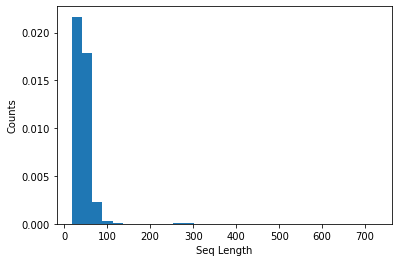

In [ ]:
#Find max seq length

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

all_len = []

for index, row in tqdm(train_df[:10000].iterrows(), total=10000):#df.shape[0]):
  topic, sent1, sent2 = row["startphrase"], row["sent1"], row["sent2"]
  input_ids = tokenizer.encode(topic+" : "+sent1, topic+" : "+sent2, add_special_tokens=True, return_tensors = 'pt')
  all_len.append(len(input_ids[0]))

plt.hist(all_len, density=True, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Seq Length');


In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
from transformers import BertTokenizer

class PrecondData(Dataset):

  def __init__(self, train_df, val_df):
    ''' "<" the first sentence is the precondition
        ">" the second sentence is the precondition
        "?" no obvious dependency information between the two
    '''
    self.label_dict = {'<': 0, '>': 1, '?': 2}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 100
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []
    startphrases = df['startphrase'].to_list()
    sentence1s = df['sent1'].to_list()
    sentence2s = df['sent2'].to_list()
    labels = df['label'].to_list()

    for (topic, sent1, sent2, label) in zip(startphrases, sentence1s, sentence2s, labels):
      input1_id = self.tokenizer.encode(topic+" : "+sent1, max_length = MAX_LEN, add_special_tokens = False)
      input2_id = self.tokenizer.encode(topic+" : "+sent2, max_length = MAX_LEN, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + input1_id + [self.tokenizer.sep_token_id] + input2_id + [self.tokenizer.sep_token_id]
      input1_len = len(input1_id)
      input2_len = len(input2_id)

      segment_ids = torch.tensor([0] * (input1_len + 2) + [1] * (input2_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (input1_len + input2_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(label)

    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
      )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
      )

    return train_loader, val_loader

dataset = PrecondData(train_df[:100000], val_df)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


100000
3099


In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
model = BertForSentenceOrder.from_pretrained('bert-base-uncased')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSentenceOrder: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSentenceOrder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSentenceOrder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

import time

EPOCHS = 2

def train(model, train_loader, val_loader, optimizer):  
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(tqdm(train_loader)):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = multi_acc(prediction, labels)

      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [ ]:
train_loader, val_loader = dataset.get_data_loaders()
train(model, train_loader, val_loader, optimizer)

100%|██████████| 3125/3125 [1:39:47<00:00,  1.92s/it]


Epoch 1: train_loss: 0.5823 train_acc: 0.6799 | val_loss: 0.4284 val_acc: 0.8067
01:40:29.89


100%|██████████| 3125/3125 [1:39:37<00:00,  1.91s/it]


Epoch 2: train_loss: 0.4316 train_acc: 0.7978 | val_loss: 0.3994 val_acc: 0.8225
01:40:20.56


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Indenpedent Study/output/model.pt")